
# 📊 Predição de Churn em Telecom com Machine Learning
### Projeto Final - Data Science - Coderhouse
**Autor:** Kauan Rios de Melo



## 📝 Storytelling: O Desafio do Negócio

Imagine uma grande operadora de telecomunicações enfrentando uma crise silenciosa: a cada mês, centenas de clientes estão cancelando seus serviços.

Cada cliente perdido representa não apenas uma queda no faturamento, mas também um aumento nos custos para adquirir novos consumidores, que são muito mais altos do que os custos para reter os existentes.

O time de Business Intelligence da empresa foi acionado com perguntas cruciais:

- **Por que** os clientes estão saindo?
- **Quem** são os clientes mais propensos a cancelar?
- **Como** podemos agir de forma antecipada para reverter esse movimento?

Como cientista de dados, nosso desafio é transformar dados brutos em inteligência acionável. Fomos encarregados de construir um modelo preditivo que não apenas identifique os clientes em risco, mas que também forneça insights para que a empresa possa criar campanhas de retenção mais eficazes e personalizadas.



## 🎯 Objetivos e Estrutura do Projeto

O objetivo principal é construir e otimizar um modelo de Machine Learning para prever o *churn* de clientes com alta precisão.

**Estrutura seguida:**
1.  **Carregamento e Limpeza dos Dados:** Preparação inicial do dataset.
2.  **Análise Exploratória de Dados (EDA):** Investigação univariada, bivariada e multivariada para extrair insights.
3.  **Pré-processamento e Engenharia de Features:** Transformação dos dados para o modelo.
4.  **Modelagem e Otimização:** Treinamento de um modelo de Regressão Logística com `GridSearchCV`.
5.  **Avaliação de Performance:** Análise do desempenho do modelo com Matriz de Confusão, Curva ROC e outras métricas.
6.  **Conclusão e Próximos Passos:** Interpretação dos resultados e sugestões para o futuro.


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
import warnings
import gc

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Carregamento e Limpeza dos Dados

In [2]:
# Carrega o dataset em excel
try:
    file_path = 'WA_Fn-UseC_-Telco-Customer-Churn.xlsx'
    df = pd.read_excel(file_path)
    print("Dataset carregado com sucesso!")
    print(f"O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")
except FileNotFoundError:
    print("ERRO: Arquivo 'WA_Fn-UseC_-Telco-Customer-Churn.xlsx' não encontrado.")
    print("Por favor, faça o upload do arquivo para o ambiente do Google Colab.")

# Visualização inicial
print("\nPrimeiras 5 linhas do dataset:")
display(df.head())

# Informações gerais sobre o dataset
print("\nInformações das colunas e tipos de dados:")
df.info()


Dataset carregado com sucesso!
O dataset possui 7043 linhas e 21 colunas.

Primeiras 5 linhas do dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn_Status
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,2985,2985.0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,5695,18895.0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,5385,10815.0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),423,184075.0,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,707,15165.0,Yes



Informações das colunas e tipos de dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16 


### Limpeza e Transformações Iniciais

Antes de iniciar a análise, realizamos algumas limpezas essenciais:
- A coluna `TotalCharges` possui valores que deveriam ser numéricos mas estão como `object`. Convertemos e tratamos os valores ausentes.
- A coluna alvo `Churn` é convertida de 'Yes'/'No' para `1`/`0`.


In [3]:
# Convertemos para numérico, e os erros (espaços) viram NaN (Not a Number)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Removemos as linhas que ficaram com NaN (são poucas e representam clientes sem histórico de cobrança)
initial_rows = df.shape[0]
df.dropna(subset=['TotalCharges'], inplace=True)
rows_dropped = initial_rows - df.shape[0]
print(f"Foram removidas {rows_dropped} linhas com 'TotalCharges' ausentes.")

# Mapeia a variável alvo para o formato numérico (0 e 1)
# Usamos uma verificação para encontrar a coluna de churn, mesmo que o nome varie
churn_col_name = [col for col in df.columns if 'churn' in col.lower()][0]
df.rename(columns={churn_col_name: 'Churn'}, inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print(f"Coluna 'Churn' convertida para formato numérico (1 para 'Yes', 0 para 'No').")

df.drop('customerID', axis=1, inplace=True)
print("Coluna 'customerID' removida.")


Foram removidas 11 linhas com 'TotalCharges' ausentes.
Coluna 'Churn' convertida para formato numérico (1 para 'Yes', 0 para 'No').
Coluna 'customerID' removida.


## 2. Análise Exploratória de Dados (EDA)


### Análise Univariada: Distribuição do Churn

Primeiro, vamos entender o balanceamento da nossa variável alvo.


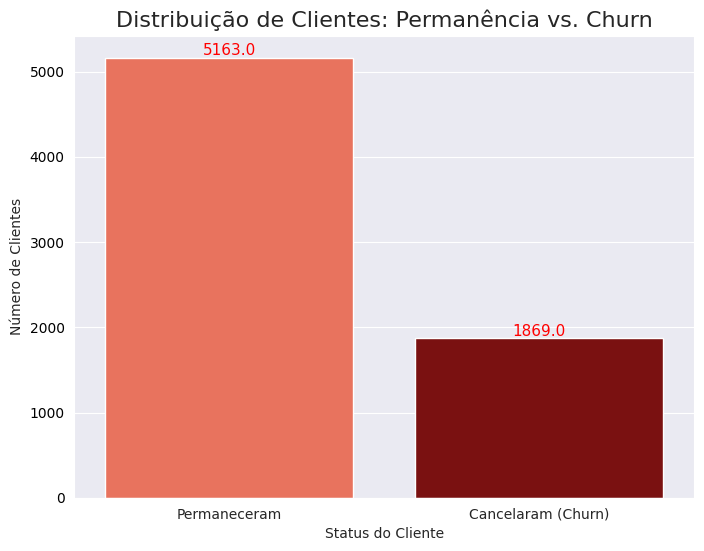


Taxa de Churn no dataset: 26.58%


In [17]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Churn', data=df, palette=['#FF6347', '#8B0000'])
plt.title('Distribuição de Clientes: Permanência vs. Churn', fontsize=16)
plt.ylabel('Número de Clientes')
plt.xlabel('Status do Cliente')
plt.xticks(ticks=[0, 1], labels=['Permaneceram', 'Cancelaram (Churn)'])
plt.yticks(color='black')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='red', xytext=(0, 5),
                textcoords='offset points')
plt.show()

churn_rate = df['Churn'].value_counts(normalize=True)[1] * 100
print(f"\nTaxa de Churn no dataset: {churn_rate:.2f}%")



### Análise Bivariada: Churn vs. Outras Variáveis

Agora, investigamos como diferentes características dos clientes se relacionam com a probabilidade de churn.


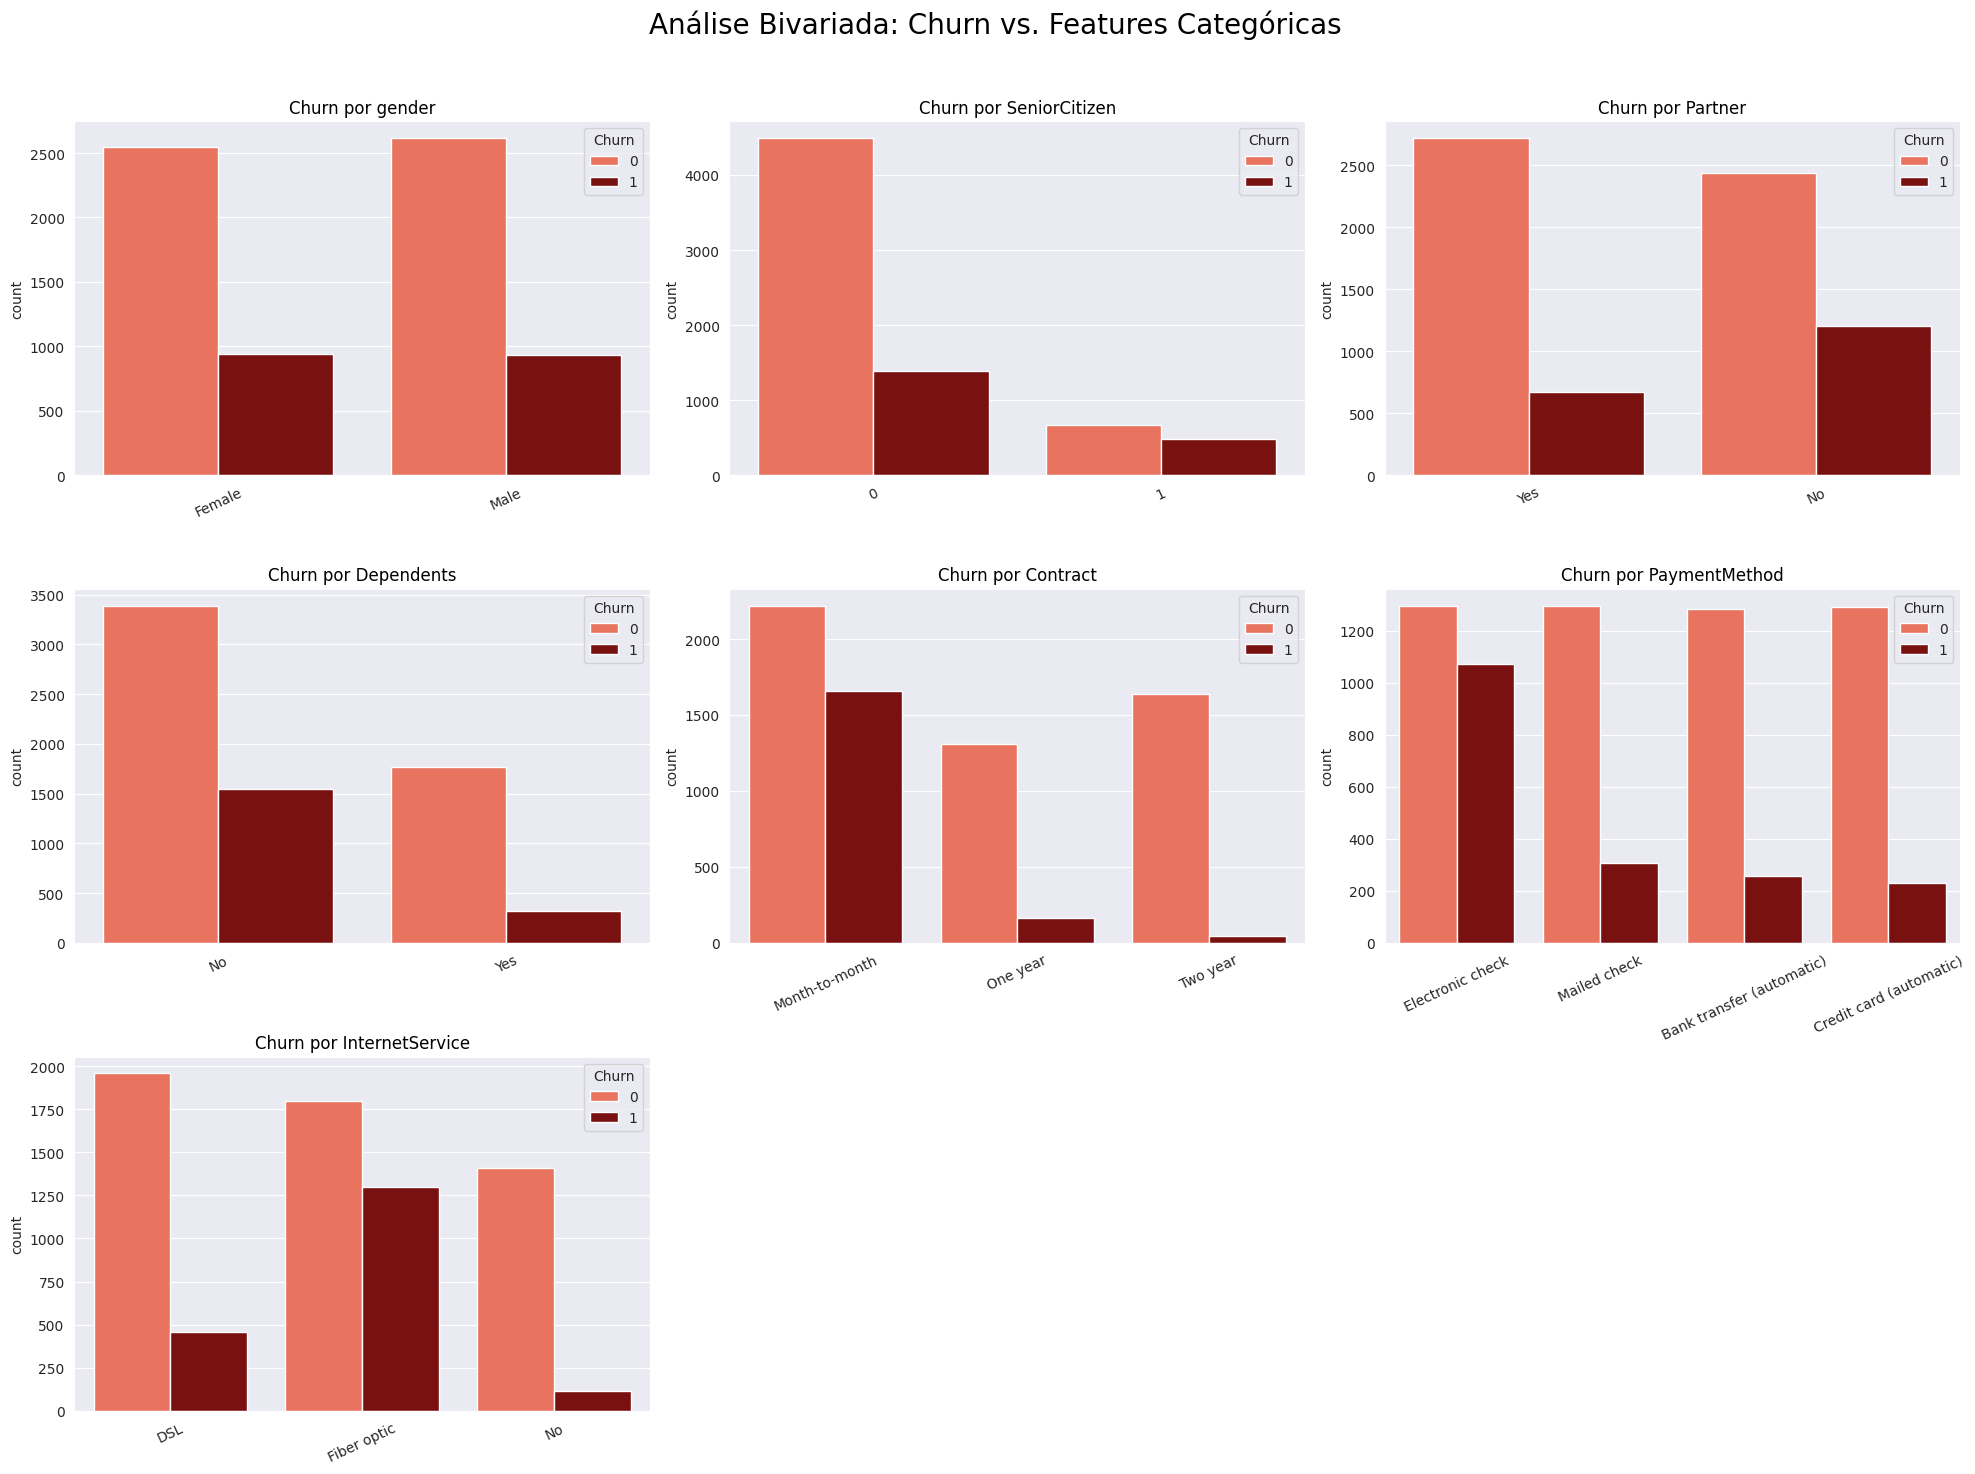

In [19]:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaymentMethod', 'InternetService']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
fig.suptitle('Análise Bivariada: Churn vs. Features Categóricas', fontsize=20, color='black')
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[i], palette=['#FF6347', '#8B0000'])
    axes[i].set_title(f'Churn por {col}', color='black')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=25)

for j in range(len(categorical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



### Análise Multivariada: Matriz de Correlação

Analisamos a correlação entre as variáveis numéricas e a variável `Churn`. Isso ajuda a identificar quais fatores numéricos estão mais fortemente associados ao cancelamento.


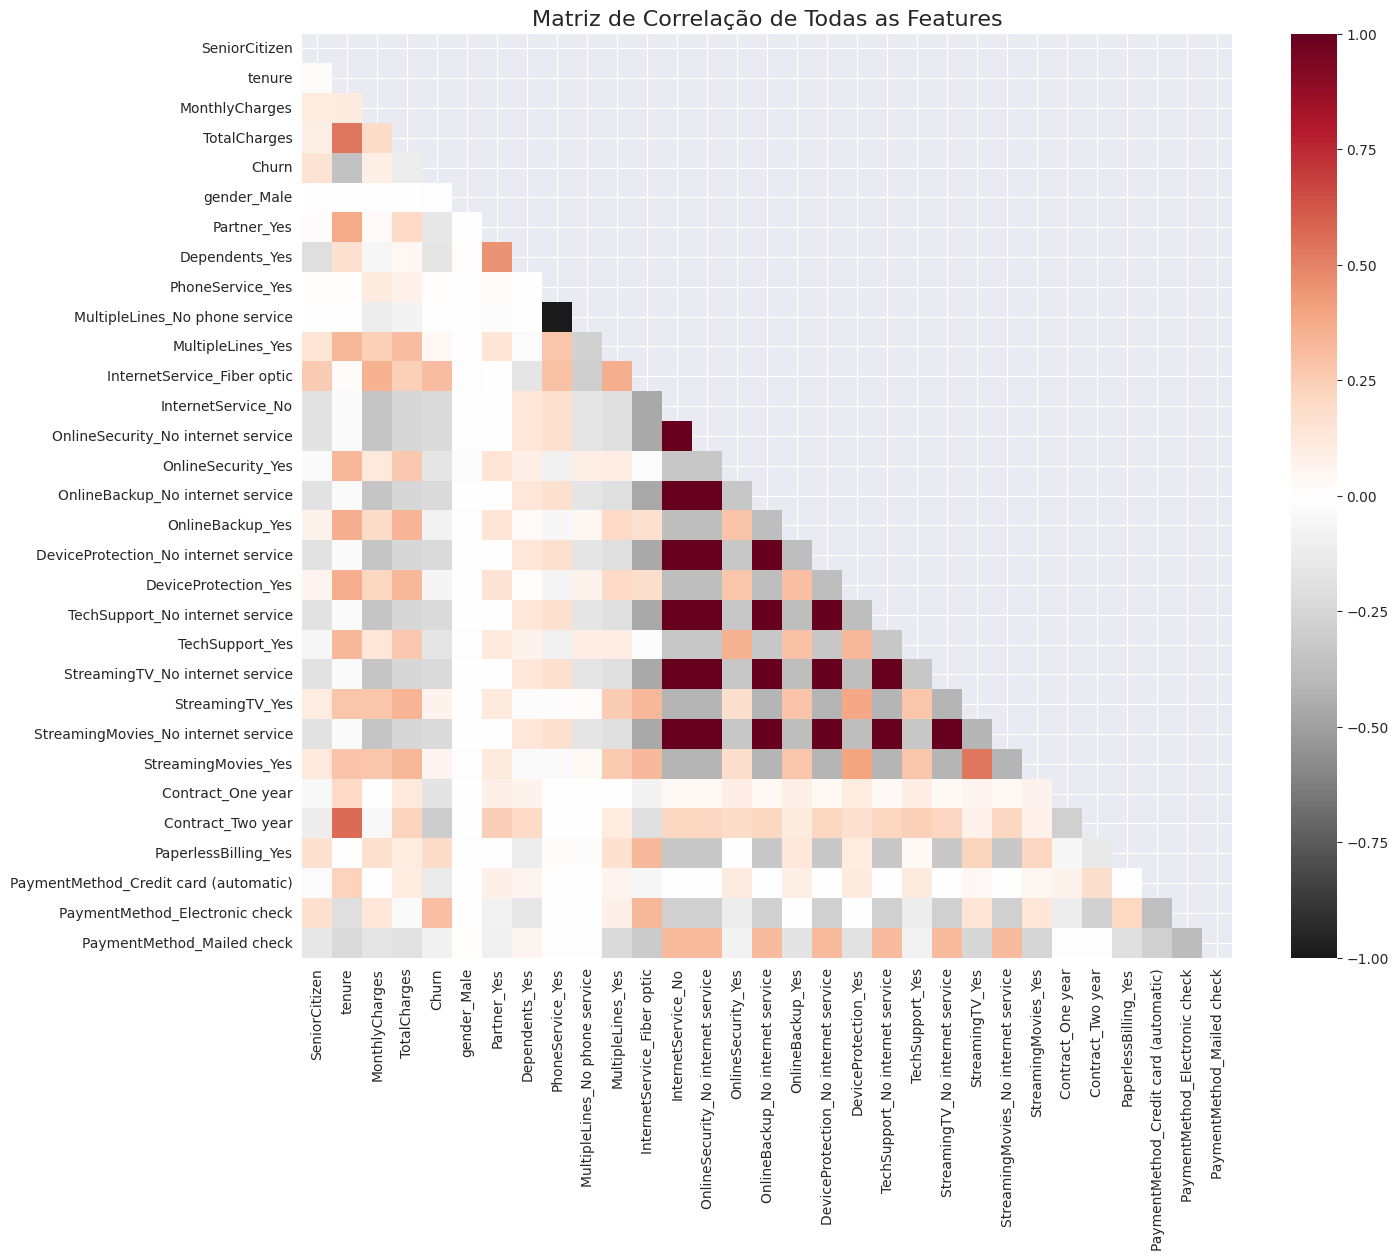


Top correlações com a variável 'Churn':
Churn                             1.000000
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
PaperlessBilling_Yes              0.191454
SeniorCitizen                     0.150541
MonthlyCharges                    0.092765
StreamingTV_Yes                   0.063254
StreamingMovies_Yes               0.060860
MultipleLines_Yes                 0.040033
PhoneService_Yes                  0.011691
Name: Churn, dtype: float64

Menores correlações com a variável 'Churn':
Contract_One year                      -0.178225
InternetService_No                     -0.227578
StreamingTV_No internet service        -0.227578
OnlineSecurity_No internet service     -0.227578
OnlineBackup_No internet service       -0.227578
DeviceProtection_No internet service   -0.227578
StreamingMovies_No internet service    -0.227578
TechSupport_No internet service        -0.227578
Contract_Two year                      -0.301552
tenure         

In [20]:
df_dummies = pd.get_dummies(df, drop_first=True)

plt.figure(figsize=(15, 12))
corr = df_dummies.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='RdGy_r', annot=False, fmt=".2f")
plt.title('Matriz de Correlação de Todas as Features', fontsize=16)
plt.show()

churn_corr = corr['Churn'].sort_values(ascending=False)
print("\nTop correlações com a variável 'Churn':")
print(churn_corr.head(10))
print("\nMenores correlações com a variável 'Churn':")
print(churn_corr.tail(10))


## 3. Pré-processamento para Modelagem

In [21]:
# X são as features preditores),y é a variável alvo o Churn
X = df_dummies.drop('Churn', axis=1)
y = df_dummies['Churn']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Padroniza as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dados divididos: {X_train.shape[0]} para treino e {X_test.shape[0]} para teste.")

Dados divididos: 5274 para treino e 1758 para teste.


## 4. Modelagem com Regressão Logística e Otimização com GridSearchCV


Utilizamos **Regressão Logística**, um algoritmo robusto e interpretável para classificação. Para encontrar a melhor combinação de hiperparâmetros, aplicamos **GridSearchCV**, que testa exaustivamente diferentes configurações e seleciona a melhor com base em validação cruzada.


In [29]:
# Definindo os parâmetros para o GridSearch
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Criando o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Treinando o modelo
print("Iniciando a busca pelos melhores hiperparâmetros...")
grid_search.fit(X_train_scaled, y_train)

# Exibi os melhores resultados
print("\nBusca finalizada!")
print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")
print(f"Melhor F1-Score (validação cruzada): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_


Iniciando a busca pelos melhores hiperparâmetros...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Busca finalizada!
Melhores parâmetros encontrados: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Melhor F1-Score (validação cruzada): 0.6315


## 5. Avaliação de Performance do Modelo Otimizado

Avaliamos o modelo final no conjunto de **teste**, que ele nunca viu durante o treinamento.

--- Relatório de Classificação (Dados de Teste) ---
              precision    recall  f1-score   support

Permaneceram       0.90      0.72      0.80      1291
  Cancelaram       0.50      0.79      0.61       467

    accuracy                           0.74      1758
   macro avg       0.70      0.75      0.71      1758
weighted avg       0.80      0.74      0.75      1758


--- Matriz de Confusão ---


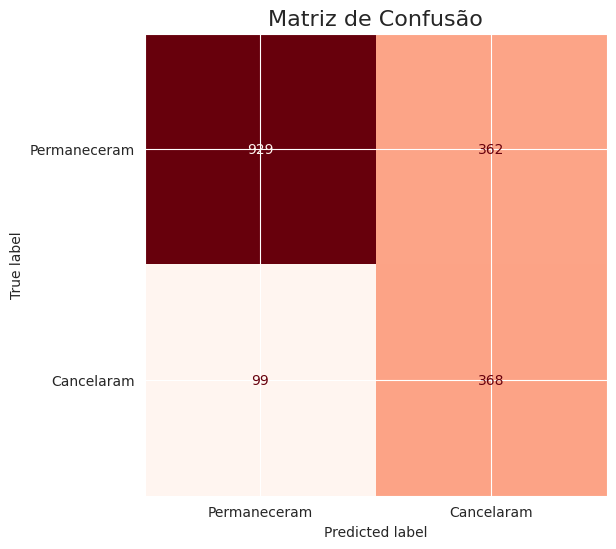

In [23]:

# Conjunto de teste
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Relatório
print("--- Relatório de Classificação (Dados de Teste) ---")
print(classification_report(y_test, y_pred, target_names=['Permaneceram', 'Cancelaram']))

# Matriz
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Permaneceram', 'Cancelaram'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Reds', colorbar=False)
plt.title('Matriz de Confusão', fontsize=16)
plt.show()


### Curva ROC e AUC

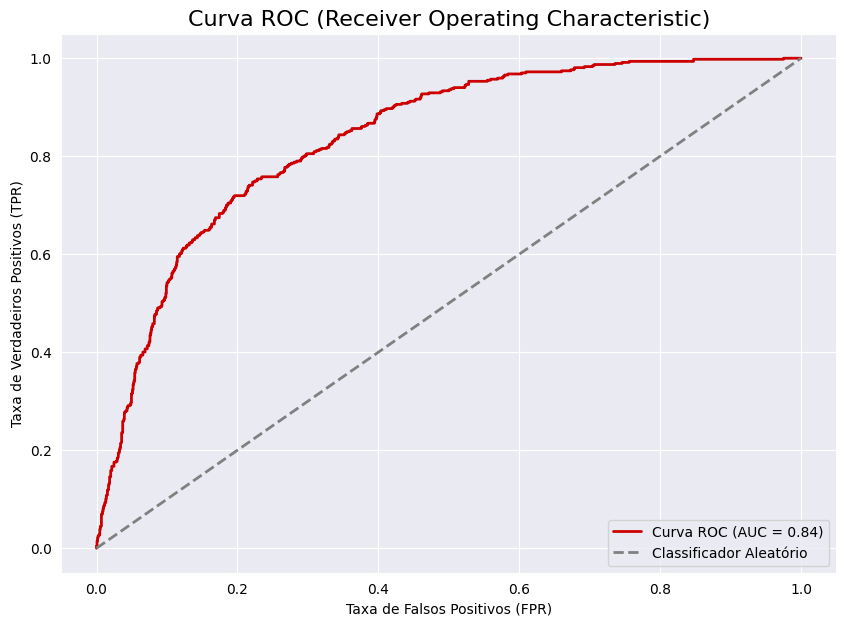

In [28]:
# Cálcula a Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plot Curva ROC
plt.figure(figsize=(10, 7))

fig.set_facecolor('black')
ax.set_facecolor('black')

plt.plot(fpr, tpr, color='#CC0000', lw=2, label=f'Curva ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Classificador Aleatório')
plt.xlabel('Taxa de Falsos Positivos (FPR)', color='black')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', color='black')
plt.title('Curva ROC (Receiver Operating Characteristic)', fontsize=16, color='black')
plt.xticks(color='black')
plt.yticks(color='black')
legend = plt.legend(loc='lower right')
for text in legend.get_texts():

    text.set_color('black')

plt.grid(True)
plt.show()


## 6. Conclusões e Próximos Passos


### Conclusões do Projeto
O modelo de Regressão Logística, após otimização com GridSearchCV, demonstrou uma **performance sólida** para prever o churn de clientes. As principais descobertas da análise exploratória indicam que fatores como **tipo de contrato (mensal), tempo de serviço (baixo) e serviços como suporte técnico e segurança online** são cruciais na decisão do cliente de cancelar.

A Matriz de Confusão e a alta pontuação AUC confirmam que o modelo é significativamente melhor do que uma escolha aleatória e consegue identificar corretamente uma boa parte dos clientes que de fato cancelarão o serviço.

### Ações de Negócio Sugeridas
1.  **Campanhas de Retenção Focadas:** Utilizar a lista de clientes com alta probabilidade de churn (gerada pelo modelo) para oferecer descontos, upgrades ou planos de fidelidade.
2.  **Melhorar a Oferta para Contratos Mensais:** Clientes com contrato mensal são os mais propensos a sair. Criar ofertas para migrá-los para contratos anuais pode aumentar a retenção.
3.  **Investir em Suporte Técnico:** A falta de suporte técnico de qualidade parece ser um grande fator de churn. Melhorar este serviço pode ter um impacto direto na satisfação do cliente.

### Próximos Passos Técnicos
- **Testar outros algoritmos:** Implementar modelos mais complexos como `Random Forest` ou `XGBoost` para comparar a performance.
- **Engenharia de Features:** Criar novas variáveis a partir das existentes (ex: `custo_por_mes_de_servico`).
- **Deploy do Modelo:** Colocar o modelo em produção através de uma API para que possa ser consumido por outros sistemas da empresa em tempo real.


## Referências


- **Dataset:** IBM Sample Dataset - [Telco Customer Churn](https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/)
- **Bibliotecas:**
  - Scikit-Learn: [scikit-learn.org](https://scikit-learn.org/)
  - Pandas: [pandas.pydata.org](https://pandas.pydata.org/)
  - Seaborn: [seaborn.pydata.org](https://seaborn.pydata.org/)
  - Matplotlib: [matplotlib.org](https://matplotlib.org/)
